# Trading Bot

The goal of this project is to implement a fully automated trading bot, generating signals from trading strategies and executing them on exchange fully autonomously. The trading bot is supposed to run on an aws server 24/7. The general structure of the bot and all the other components are shown in the following flow chart. 

![Trading Bot](./images/trading_bot.png)

In [588]:
%matplotlib inline 

# data analysis
import numpy as np
import pandas as pd
import pandas_ta
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# data communication
import urllib.parse
from urllib.parse import urlencode
from typing import Optional, Dict, Any
import requests
from requests import Session, Request, Response
import configparser
import hmac
import hashlib
import json

# utilities
import time
import math
import logging
import unittest
import calendar
import apscheduler
from abc import ABC, abstractmethod
from datetime import datetime, timedelta
from apscheduler.schedulers.blocking import BlockingScheduler
from tqdm import tqdm

## Exchange Client

The exchange client establishes a connection with the REST Api of the exchange and handles data requests and trading orders.

![Trading Bot](./images/exchange_client.png)

In [589]:
class ExchangeClient:
    """Provides an interface for the trading bot to communicate with an exchange via its' API."""
    
    def __init__(self, endpoint: str):
        self.maker_fees_USD_futures = 0.0002
        self.taker_fees_USD_futures = 0.0004
        self._session = None
        self._config = None
        self._api_key = None
        self._api_secret = None
        self._endpoint = endpoint
        
        
    def open_session(self) -> None:
        """Opens a session with the exchange server."""
        
        self._session = Session()
        
        
    def read_config(self) -> None:
        """Initializes the Exchange client."""
        
        self._config = configparser.ConfigParser()
        self._config.read('config.ini')
        
        self._api_key = self._config['BINANCE API']['api_key']
        self._api_secret = self._config['BINANCE API']['api_secret']
        
        
    def _process_response(self, response: Response) -> Any:
        """Processes the response the server sends to the clients request."""
        
        try:
            data = response.json()
        except ValueError:
            response.raise_for_status()
            raise
        else:
            return data
    
    
    def _sign_request(self, request: Request) -> None:
        """Signs confidential requests that need the users API key and API secret."""
        
        ts = int(time.time() * 1000)
        request.params['timestamp'] = str(ts)
        signature_payload = urlencode(request.params).encode("utf-8")
        signature = hmac.new(self.api_secret.encode("utf-8"), signature_payload, hashlib.sha256).hexdigest()
        request.headers['X-MBX-APIKEY'] = self._api_key
        request.params['signature'] = signature
        
        
    def _request(self, method: str, path: str,**kwargs,) -> Any:
        """Executes a non-confidential request to the exchange server."""
        
        request = Request(method, self._endpoint + path, **kwargs)
        
        try:
            response = self._session.send(request.prepare())
        except requests.exceptions.Timeout:
            logging.warning("Request has timed out")
        except requests.exceptions.ConnectionError:
            logging.warning("Request has faced a connection error")
            
        return self._process_response(response)
    
    
    def _signed_request(self, method: str, path: str, params, **kwargs) -> Any:
        """Executes a confidential request to the exchange server"""
        
        request = Request(method, self._endpoint + path, params=params, **kwargs)
        self._sign_request(request)
        
        try:
            response = self._session.send(request.prepare())
        except requests.exceptions.Timeout:
            logging.warning("Signed request has timed out")
        except requests.exceptions.ConnectionError:
            logging.warning("Signed request has faced a connection error")
        
        return self.process_response(response)
        
        
    def get(self, path: str, params: Optional[Dict[str, Any]] = None) -> Any:
        """Executes an HTTPS GET request."""
        
        return self._request('GET', path, params=params)
    
    
    def post(self, path: str, params: Optional[Dict[str, Any]] = None) -> Any:
        """Executes an HTTPS POST request."""
        
        return self._signed_request('POST', path, params=params)
    
    
    def delete(self, path: str, params: Optional[Dict[str, Any]] = None) -> Any:
        """Executes an HTTPS DELETE request."""
        
        return self._signed_request('DELETE', path, json=params)
    
    
    def place_order(self, market: str, side: str, size: float, reduce_only: bool = False,
                    order_type: str = 'MARKET') -> dict:
        """Places a buy or sell order with the exchange."""
        
        return self.post('fapi/v1/order', params={
            'symbol': market,
            'side': side,
            'type': order_type,
            'quantity': size,
            "reduceOnly": reduce_only
        })

## Market Structure

The price data series of every asset has a particular structure, the so called market structure. The market has five different states and can not transition from each state into any other state discretionary. The states and transitions of market structure are shown in the following flow chart.

![Market Structure](./images/market_structure.png)

The MarketStructure class represents the current state of the market and can transition from the current state into another state as new data comes in via the next_candle method.

In [590]:
class MarketStructure:
    """Represents the market structure of an asset at one point in time."""
    
    def __init__(self, prev_high: tuple, prev_low: tuple, 
                 provisional_high: tuple, provisional_low: tuple,
                 recent_break: bool = False):
        self.msb = False
        self.stay_in_range = False
        self.continuation = False
        self.trend = False
        self.prev_high = prev_high
        self.prev_low = prev_low
        self.provisional_high = provisional_high
        self.provisional_low = provisional_low
        self.recent_break = recent_break
        
        
    def _break_up_trend(self, row: pd.Series) -> None:
        """Sets the new market structure after break of an up trend."""
        
        self.trend = False
        self.prev_high = self.provisional_high
        self.prev_low = tuple(row[['low', 'open time']])
        self.provisional_low = tuple(row[['low', 'open time']])
        logging.info('Up Trend Broken')
        
        
    def _break_down_trend(self, row: pd.Series) -> None:
        """Sets the new market structure after break of a down trend."""
        
        self.trend = True
        self.prev_high = tuple(row[['high', 'open time']])
        self.prev_low = self.provisional_low
        self.provisional_high = tuple(row[['high', 'open time']])
        logging.info('Down Trend Broken')
        
        
    def _continue_up_trend(self, row: pd.Series) -> None:
        """Sets the new market structure after an up trend continues."""
        
        self.prev_low = self.provisional_low
        self.prev_high = tuple(row[['high', 'open time']])
        self.provisional_high = tuple(row[['high', 'open time']])
        logging.info('Continuing Up Trend')
        
        
    def _continue_down_trend(self, row: pd.Series) -> None:
        """Sets the new market structure after a down trend continues."""
        
        self.prev_high = self.provisional_high
        self.prev_low = tuple(row[['low', 'open time']])
        self.provisional_low = tuple(row[['low', 'open time']])
        logging.info('Continuing Down Trend')
        

    def _stay_in_range(self, row: pd.Series) -> None:
        """Keeps track of provisional information while range bound."""
        
        if row['close'] - row['open'] >= 0:
            self.provisional_high = tuple(row[['high', 'open time']])
        if row['close'] - row['open'] < 0:
            self.provisional_low = tuple(row[['low', 'open time']])
        logging.info('Staying in Range')
        
        
    def next_candle(self, row: pd.Series) -> Any:
        """Investigates how the market structure changes with the next incoming price data candle."""
        
        close = row['close']
        self.msb = False
        self.continuation = False
        self.stay_in_range = False
        trend = self.trend
        
        if close > self.prev_high[0]:
            if self.trend == False:
                self._break_down_trend(row)
                self.msb = True
            else:
                self._continue_up_trend(row)
                self.continuation = True
        elif close < self.prev_low[0]:
            if self.trend == False:
                self._continue_down_trend(row)
                self.continuation = True
            else:
                self._break_up_trend(row)
                self.msb = True
        else:
            self._stay_in_range(row)
            self.stay_in_range = True
            
        return trend, self.msb, self.continuation, self.stay_in_range

## Strategy

The abstract base class Strategy implements all methods that are common to all strategies such as buying long, selling short, and closing trades as well as a set of abstract methods for the trading logic, that each strategy has to have, but the details of the implementation of which are different for each particular strategy.

In [591]:
class Strategy(ABC):
    """Implements generic functions of trades that are common amongst all particular trading strategies
       such as buying and selling."""
    
    def __init__(self, ec: ExchangeClient, ms: MarketStructure, market_name: str, equity: float, 
                 max_risk: float, max_leverage: float = 1.0, timeframe: str = '1h', live: bool = False):
        self.ms = ms
        self.ec = ec
        self.timeframe = timeframe
        self.equity_curve = [equity]
        self.position_size = [0]
        self.num_trades = 0
        self.wins = 0
        self.win_rate = 0
        self._position = 0
        self._long_trigger = False
        self._long_position = False
        self._short_trigger = False
        self._short_position = False
        self._entry = None
        self._stop_loss = None
        self._target = None
        self._live = live
        self._equity = equity
        self._max_risk = max_risk
        self._max_leverage = max_leverage
        self._market_name = market_name

    @abstractmethod
    def _entry_long(self, row: pd.Series) -> None:
        """Looking for an entry to a long trade after a signal has been triggered."""
        
        pass

    @abstractmethod
    def _exit_long(self, row: pd.Series) -> None:
        """Checks if an open long trade has to be closed."""
        
        pass

    @abstractmethod
    def _entry_short(self, row: pd.Series) -> None:
        """Looking for an entry to a short trade after a signal has been triggered."""
        
        pass

    @abstractmethod
    def _exit_short(self, row: pd.Series) -> None:
        """Checks if an open short trade has to be closed."""
        
        pass

    @abstractmethod
    def _setup_trade(self, row: pd.Series) -> None:
        """Activates trade triggers and sets stop losses."""
        
        pass

    @abstractmethod
    def _execute_trade(self, row: pd.Series) -> None:
        """Enters trade after triggered and follows through until trade exit."""
        
        pass

    @abstractmethod
    def next_candle_init(self, row: pd.Series) -> None:
        """Initializes the strategy by iterating through historical data without executing trades."""
        
        pass

    @abstractmethod
    def next_candle_live(self, row: pd.Series) -> None:
        """Checks for valid trade set ups with new live data and execute live trades."""
        
        pass
    
    @property
    def equity(self) -> float:
        """Returns the current equity value of the strategy."""
        
        if self._long_position or self._short_position:
            return (self._position*self.close) + self._equity
        else:
            return self._equity
    
    
    def plot_equity_curve(self) -> None:
        """Plots the equity curve of the strategy."""
        
        plt.plot(self.equity_curve)
        plt.show()
        
        
    def plot_position_size(self) -> None:
        """Plots the position size of the strategy over time."""
        
        plt.plot(self._position_size)
        plt.show()
        
        
    def _long(self, price: float, risk: float) -> None:
        """Enters a long trade."""
        
        trade_size = min(self._max_leverage*self._equity, 
                         (self._max_risk/risk) * self._equity)
        coins = round(((1.-self.ec.taker_fees_USD_futures)*trade_size)/price, 3)
        self._position += coins
        if self._live:
            self.ec.place_order(self._market_name, 'BUY', coins, reduce_only=False, order_type='MARKET')
        self._equity -= trade_size
        logging.info('Entered New Long Position')


    def _short(self, price: float, risk: float) -> None:
        """Enters a short trade."""
        
        trade_size = min(self._max_leverage*self._equity, 
                         (self._max_risk/risk) * self._equity)
        coins = round(((1-self.ec.taker_fees_USD_futures)*trade_size)/price, 3)
        self._position -= coins
        if self._live:
            self.ec.place_order(self._market_name, 'SELL', coins, reduce_only=False, order_type='MARKET')
        self._equity += (1.-self.ec.taker_fees_USD_futures) * trade_size
        logging.info('Entered New Short Position')        
        

    def _close_long_trade(self, price: float) -> None:
        """Closes an open long or short positoin."""
        
        cash = self._position*price
        if self._live:
            self.ec.place_order(self._market_name, 'SELL', self._position, reduce_only=True, order_type='MARKET')
        self._equity += (1.-self.ec.taker_fees_USD_futures) * cash
        self._position = 0
        
        
    def _close_short_trade(self, price: float) -> None:
        """Closes an open long or short positoin."""
        
        cash = self._position*price
        if self._live:
            self.ec.place_order(self._market_name, 'BUY', self._position, reduce_only=True, order_type='MARKET')
        self._equity += (1.-self.ec.taker_fees_USD_futures) * cash
        self._position = 0

# Reversal Trade

The ReversalTrade class is a first implementation of the abstract Strategy class, implementing a trend reversal strategy.


![Market Structure](./images/strategies.png)

In [592]:
class ReversalTrade(Strategy):
    """Implements the logical rules for a trend reversal trade triggered by an initial market structure break."""
             
    def __init__(self, ec: ExchangeClient, ms: MarketStructure, market_name: str, equity: float,
                max_risk: float, max_leverage: float = 1.0, timeframe: str = '1h', live: bool = False,
                risk_reward: float = 2.0):
        super(ReversalTrade, self).__init__(ec, ms, market_name, equity, max_risk, max_leverage, 
                                            timeframe, live)
        self._risk_reward = risk_reward
        
        
    def _entry_long(self, row: pd.Series) -> None:
        """Looking for an entry to a long trade after a signal has been triggered."""
        
        price = row['close']
        if price <= self.ms.prev_low[0]:
            self._long_trigger = False
        elif price >= self.ms.prev_high[0] and not self.ms.continuation:
            self._long_trigger = False
        else:
            if price <= self._entry:
                risk = price - self._stop_loss
                reward_risk = (self.ms.prev_high[0] - price)/risk
                if reward_risk >= self._risk_reward:
                    self._long(price, risk/price)
                    self._target = self.ms.prev_high[0]
                    self.num_trades += 1
                    self._long_position = True
                    self._long_trigger = False
        
                        
    def _exit_long(self, row: pd.Series) -> None:
        """Checks if an open long trade has to be closed."""
        
        price = row['close']
        if price > self._target:
            self._close_long_trade(price)
            logging.info('Take Profit on Long Position')
            self._long_position = False
            self.wins += 1
            self.win_rate = self.wins/self.num_trades
        if price < self._stop_loss:
            self._close_long_trade(price)
            logging.info('Stop Loss Hit on Long Position')
            self._long_position = False 
            
            
    def _entry_short(self, row: pd.Series) -> None:
        """Looking for an entry to a short trade after a signal has been triggered."""
        
        price = row['close']
        if price >= self.ms.prev_high[0]:
            self._short_trigger = False
        elif price <= self.ms.prev_low[0] and not self.ms.continuation:
            self._long_trigger = False
        else:
            if price >= self._entry:
                risk = self._stop_loss - price
                reward_risk = (price-self.ms.prev_low[0])/risk
                if reward_risk >= self._risk_reward:
                    self._short(price, risk/price)
                    self._target = self.ms.prev_low[0]
                    self.num_trades += 1
                    self._short_position = True
                    self._short_trigger = False
            
            
    def _exit_short(self, row: pd.Series) -> None:
        """Checks if an open short trade has to be closed."""
        
        price = row['close']
        if price < self._target:
            self._close_short_trade(price)
            logging.info('Take Profit on Short Position')
            self._short_position = False
            self.wins += 1
            self.win_rate = self.wins/self.num_trades
        if price > self._stop_loss:
            self._close_short_trade(price)
            logging.info('Stop Loss Hit on Short Position')
            self._short_position = False

            
    def _setup_trade(self, row: pd.Series) -> None:
        """Activates trade triggers and sets stop losses."""
        
        trend, msb, continuation, stay_in_range = self.ms.next_candle(row)
        self.close = row['close']
        
        if msb and (not trend):
            self._entry = self.ms.prev_high[0]
            self._stop_loss = self.ms.provisional_low[0]
            self._long_trigger = True
        elif msb and trend:
            self._entry = self.ms.prev_low[0]
            self._stop_loss = self.ms.provisional_high[0]
            self._short_trigger = True
            
        if not self._live:
            self.position_size.append(self._position)
            self.equity_curve.append(self.equity)
        
        
    def _execute_trade(self, row: pd.Series) -> None:
        """Enters trade after triggered and follows through until trade exit."""
        
        if self._long_trigger:
            self._entry_long(row)
        if self._long_position:
            self._exit_long(row)
        if self._short_trigger:
            self._entry_short(row)
        if self._short_position:
            self._exit_short(row)
            
            
    def next_candle_init(self, row: pd.Series) -> None:
        """Initializes the strategy by iterating through historical data without executing trades."""
        self._setup_trade(row)
    
    
    def next_candle_live(self, row: pd.Series) -> None:
        """Checks for valid trade set ups with new live data and execute live trades."""
        
        self._execute_trade(row)
        self._setup_trade(row)

## Continuation Trade

The Continuation Trade class is a second implementation of the abstract Strategy class, implementing a trend continuation strategy.

Two strategies are enough to show the capabilities of the trading bot to its' fullest extent. Nonetheless, many more strategies are supposed to be thought up and implemented in the future. This is where the main work will take place in the future.

In [593]:
class ContinuationTrade(Strategy):
    """Implements the logical rules for a trend reversal trade triggered by an initial market structure break."""
             
    def __init__(self, ec: ExchangeClient, ms: MarketStructure, market_name: str, equity: float, 
                max_risk: float, max_leverage: float, timeframe: str = '1h', live: bool = False,
                risk_reward: float = 2.0):
        super(ContinuationTrade, self).__init__(ec, ms, market_name, equity, max_risk, max_leverage, 
                                                timeframe, live)
        self._risk_reward = risk_reward
        
        
    def _entry_long(self, row: pd.Series) -> None:
        """Looking for an entry to a long trade after a signal has been triggered."""

        price = row['close']
        if price <= self.ms.prev_low[0]:
            self._long_trigger = False
        elif price >= self.ms.prev_high[0] and not self.ms.continuation:
            self._long_trigger = False
        else:
            if price <= self._entry:
                target = self.ms.prev_high[0] 
                risk = price - self._stop_loss
                reward_risk = (target - price)/risk
                if reward_risk >= self._risk_reward:
                    self._long(price, risk/price)
                    self._target = target 
                    self.num_trades += 1
                    self._long_position = True
                    self._long_trigger = False
    

    def _exit_long(self, row: pd.Series) -> None:
        """Checks if an open long trade has to be closed."""
        
        price = row['close']
        if price > self._target:
            self._close_long_trade(price)
            logging.info('Take Profit on Long Position')
            self._long_position = False
            self.wins += 1
            self.win_rate = self.wins/self.num_trades
        if price < self._stop_loss:
            self._close_long_trade(price)
            logging.info('Stop Loss Hit on Long Position')
            self._long_position = False
            
            
    def _entry_short(self, row: pd.Series) -> None:
        """Looking for an entry to a short trade after a signal has been triggered."""
        
        price = row['close']
        if price >= self.ms.prev_high[0]:
            self._short_trigger = False
        elif price <= self.ms.prev_low[0] and not self.ms.continuation:
            self._short_trigger = False
        else:
            if price >= self._entry:
                risk = self._stop_loss - price
                reward_risk = (price - self.ms.prev_low[0])/risk
                if reward_risk >= self._risk_reward:
                    self._short(price, risk/price)
                    self._target = self.ms.prev_low[0]
                    self.num_trades += 1
                    self._short_position = True
                    self._short_trigger = False
            
            
    def _exit_short(self, row: pd.Series) -> None:
        """Checks if an open short trade has to be closed."""
        
        price = row['close']
        if price < self._target:
            self._close_short_trade(price)
            logging.info('Take Profit on Short Position')
            self._short_position = False
            self.wins += 1
            self.win_rate = self.wins/self.num_trades
        if price > self._stop_loss:
            self._close_short_trade(price)
            logging.info('Stop Loss Hit on Short Position')
            self._short_position = False

            
    def _setup_trade(self, row: pd.Series) -> None:
        """Activates trade triggers and sets stop losses."""
        
        trend, msb, continuation, stay_in_range = self.ms.next_candle(row)
        self.close = row['close']
        
        if continuation and trend:
            self._entry = 0.66*self.ms.prev_low[0] + 0.33*self.ms.prev_high[0]
            self._stop_loss = self.ms.prev_low[0]
            self._long_trigger = True
        elif continuation and (not trend):
            self._entry = 0.66*self.ms.prev_high[0] + 0.33*self.ms.prev_low[0]
            self._stop_loss = self.ms.prev_high[0]
            self._short_trigger = True
            
        if not self._live:
            self.position_size.append(self._position)
            self.equity_curve.append(self.equity)
        
        
    def _execute_trade(self, row: pd.Series) -> None:
        """Enters trade after triggered and follows through until trade exit."""
        
        if self._long_trigger:
            self._entry_long(row)
        if self._long_position:
            self._exit_long(row)
        if self._short_trigger:
            self._entry_short(row)
        if self._short_position:
            self._exit_short(row)
            
            
    def next_candle_init(self, row: pd.Series) -> None:
        """Initializes the strategy by iterating through historical data without executing trades."""
        self._setup_trade(row)
    
    
    def next_candle_live(self, row: pd.Series) -> None:
        """Checks for valid trade set ups with new live data and execute live trades."""
        
        self._execute_trade(row)
        self._setup_trade(row)

## Portfolio

The Portfolio class collects several Strategy objects into a portfolio of strategies.

In [594]:
class Portfolio:
    """Collect several trading strategies into a portfolio of trading strategies."""
    
    def __init__(self, ec: ExchangeClient, strategies: list = []):
        self.strategies = strategies
        self._ec = ec
    
    
    def add_strategy(self, strategy: Strategy) -> None:
        """Add a new strategy to the portfolio."""

        self.strategies.append(strategy)
        
    
    def plot_equity(self) -> None:
        """Plot the portfolios equity curve"""
        
        for idx, strat in enumerate(self.strategies):
            if idx == 0:
                pf = strat[1].equity_curve
            else:
                pf = [x+y for x, y in zip(pf, strat[1].equity_curve)]
            
        pf = [(1./len(self.strategies))*x for x in pf]

        plt.figure(figsize=(18,9))
        plt.grid(True)
        plt.plot(pf)
        plt.show()

        
    def _adjust_ts(self, ts: datetime.timestamp) -> datetime.timestamp:
        """Adjusts timestamps from milliseconds to seconds."""
    
        ts /= 1000
        return ts
        

    def update_portfolio(self) -> None:
        """Update all strategies in the portfolio with new data."""

        for idx, strat in enumerate(tqdm(self.strategies)):
            start_time = strat[0]['start']
            end_time = start_time + timedelta(days=40)
            
            market_name = strat[0]['market_name']
        
            while start_time < datetime.now():
    
                response = self._ec.get(f'fapi/v1/klines?symbol={market_name}&interval={strat[1].timeframe}'
                                    + f'&startTime={int(start_time.timestamp()*1000)}'
                                    + f'&endTime={int(end_time.timestamp()*1000)}&limit={1000}')
                df = pd.DataFrame(response, columns = ['open time', 'open', 'high', 'low', 'close', 
                                                   'volume', 'close time', 'quote asset volume', 
                                                   'number of trades', 'taker buy base asset volume',
                                                   'taker buy quote asset volume', 'unused field'])
        
                df['open time'] = df['open time'].apply(self._adjust_ts)
                df['open time'] = df['open time'].apply(datetime.fromtimestamp)
                df[['open', 'high', 'low', 'close', 'volume']] \
                    = df[['open', 'high', 'low', 'close', 'volume']].astype(float)
        
                for index, row in df.iterrows():
                    strat[1].next_candle_live(row)
    
                start_time = end_time
                end_time = end_time + timedelta(days=40)

## Assets

In [595]:
btc_cont = {'market_name': 'BTCBUSD', 'ath': (58434.0, '2021-02-21 19:00:00+00:00'), 
      'prev_low': (57465.0, '2021-02-21 18:00:00+00:00'),
      'start': datetime(2021, 2, 21, 20, 0, 0, 0), 'initial_equity': 1000, 'timeframe': '1h',
      'max risk': 0.1, 'leverage': 1.0, 'r/r': 2.0, 'cont': True}

eth_cont = {'market_name': 'ETHBUSD', 'ath': (4875.4, '2021-11-10 14:00:00+00:00'),
      'prev_low': (4697.8, '2021-11-10 12:00:00+00:00'),
      'start': datetime(2021, 11, 10, 15, 0, 0, 0), 'initial_equity': 1000, 'timeframe': '1h',
      'max risk': 0.05, 'leverage': 1.0, 'r/r': 3.0, 'cont': True}

sol_cont = {'market_name': 'SOLBUSD', 'ath': (261.5175, '2021-11-06 21:00:00+00:00'),
      'prev_low': (252.49, '2021-11-06 20:00:00+00:00'),
      'start': datetime(2021, 11, 6, 22, 0, 0, 0), 'initial_equity': 1000, 'timeframe': '1h',
      'max risk': 0.01, 'leverage': 1.0, 'r/r': 3.0, 'cont': True}

doge_cont = {'market_name': 'DOGEBUSD', 'ath': (0.744998, '2021-05-08 04:00:00+00:00'),
      'prev_low': (0.6674, '2021-05-08 00:00:00+00:00'),
      'start': datetime(2021, 5, 8, 5, 0, 0, 0), 'initial_equity': 1000, 'timeframe': '1h',
      'max risk': 0.01, 'leverage': 3, 'r/r': 3.0, 'cont': True}

btc_rev = {'market_name': 'BTCBUSD', 'ath': (58434.0, '2021-02-21 19:00:00+00:00'), 
      'prev_low': (57465.0, '2021-02-21 18:00:00+00:00'),
      'start': datetime(2021, 2, 21, 20, 0, 0, 0), 'initial_equity': 1000, 'timeframe': '1h',
      'max risk': 0.05, 'leverage': 3.0, 'r/r': 3.0, 'cont': False}

eth_rev = {'market_name': 'ETHBUSD', 'ath': (4875.4, '2021-11-10 14:00:00+00:00'),
      'prev_low': (4697.8, '2021-11-10 12:00:00+00:00'),
      'start': datetime(2021, 11, 10, 15, 0, 0, 0), 'initial_equity': 1000, 'timeframe': '1h',
      'max risk': 0.001, 'leverage': 5.0, 'r/r': 3.0, 'cont': False}

bnb_rev = {'market_name': 'BNBBUSD', 'ath': (693.775, '2021-05-10 06:00:00+00:00'),
      'prev_low': (671.355, '2021-05-10 05:00:00+00:00'),
      'start': datetime(2021, 5, 10, 7, 0, 0, 0), 'initial_equity': 1000, 'timeframe': '1h',
      'max risk': 0.01, 'leverage': 5, 'r/r': 3.0, 'cont': False}

# Execution

Now we create an exchange client, a number of strategies, and a portfolio and run a backtest on past data to see what the performance of this particular portfolio would have been.

In [596]:
ec = ExchangeClient(endpoint = 'https://fapi.binance.com/')
ec.open_session()
ec.read_config()

In [597]:
markets = [btc_cont, eth_cont, sol_cont, doge_cont, btc_rev, eth_rev, bnb_rev]
#markets = [eth_cont, sol_cont, doge_cont, eth_rev, bnb_rev]

100%|██████████| 7/7 [03:28<00:00, 29.74s/it]


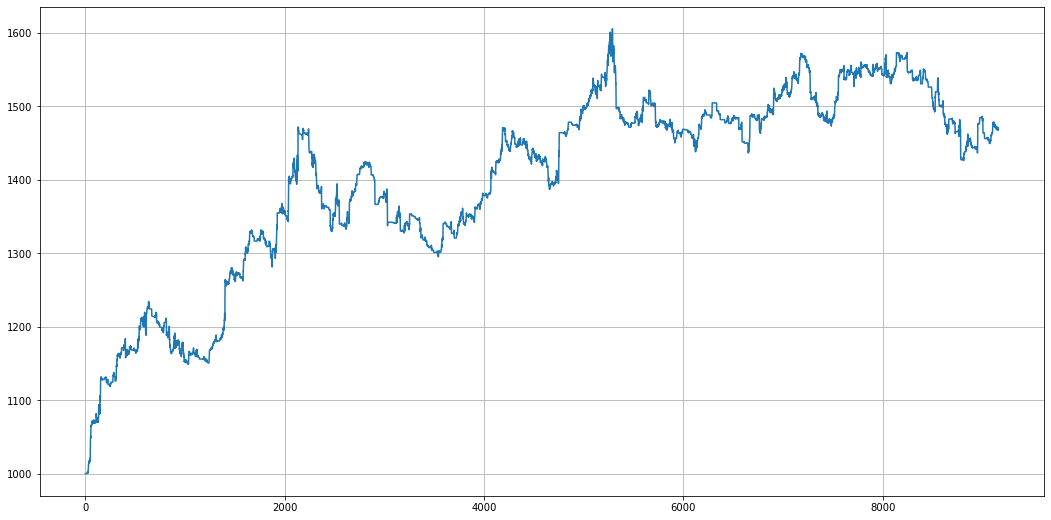

DONE!


In [598]:
portfolio = Portfolio(ec)

for idxm, market in enumerate(markets):
    
    market_name = market['market_name']
    ath = market['ath']
    prev_low = market['prev_low']
    start = market['start']
    initial_equity = market['initial_equity']
    timeframe = market['timeframe']
    
    rr = market['r/r']
    leverage = market['leverage']
    risk = market['max risk']
    cont = market['cont']
                
    ms = MarketStructure(ath, prev_low, ath, prev_low)
    
    if cont:
        strategy = ContinuationTrade(ec, ms, market_name, initial_equity, risk, max_leverage=leverage,
                                    timeframe=timeframe, live=False, risk_reward=rr)
    else:
        strategy = ReversalTrade(ec, ms, market_name, initial_equity, risk, max_leverage=leverage, 
                                timeframe=timeframe, live=False, risk_reward=rr)
        
    portfolio.add_strategy((market, strategy))

portfolio.update_portfolio()

portfolio.plot_equity()
    
print('DONE!')

# Result

We get a nicely increasing equity curve which is particularly impressive considering that the overall market has lost more than 80% of its' valuation during the timespan of our back test.

# Future Work

- Generalize the Exchange Client
- Develop more strategies